## Libraries & Data

For creating the charts, we will need to load the following libraries:

- [matplotlib](/matplotlib) for creating the chart and the arrows
- [pandas](/pandas) for loading the data
- [geopandas](/597-introduction-to-geopandas) for loading the world boundaries
- `cartopy` for changing the projections


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import cartopy.crs as ccrs

# set a higher resolution
plt.rcParams['figure.dpi'] = 300

# load the world dataset
url = "https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/all_world.geojson"
world = gpd.read_file(url)
world.head()

,name,geometry
0,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,Tanzania,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,W. Sahara,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


## What's a projection

How can we make a **2D version of a 3D object** like the Earth? This challenge is tackled through map projections, which **transform** the Earth's spherical surface into a flat map. Projections are crucial because they **inevitably distort** some aspects of the Earth's surface, such as shape, area, distance, or direction.

The choice of projection can **significantly alter the message** conveyed by a map; for instance, using a Mercator projection preserves direction but distorts the size of landmasses, making regions near the poles appear disproportionately large and potentially misleading viewers about the true scale of countries.


## Default map

Let's check how the **default** matplotlib/geopandas map looks like by using the `plot()` method on our previous dataset:


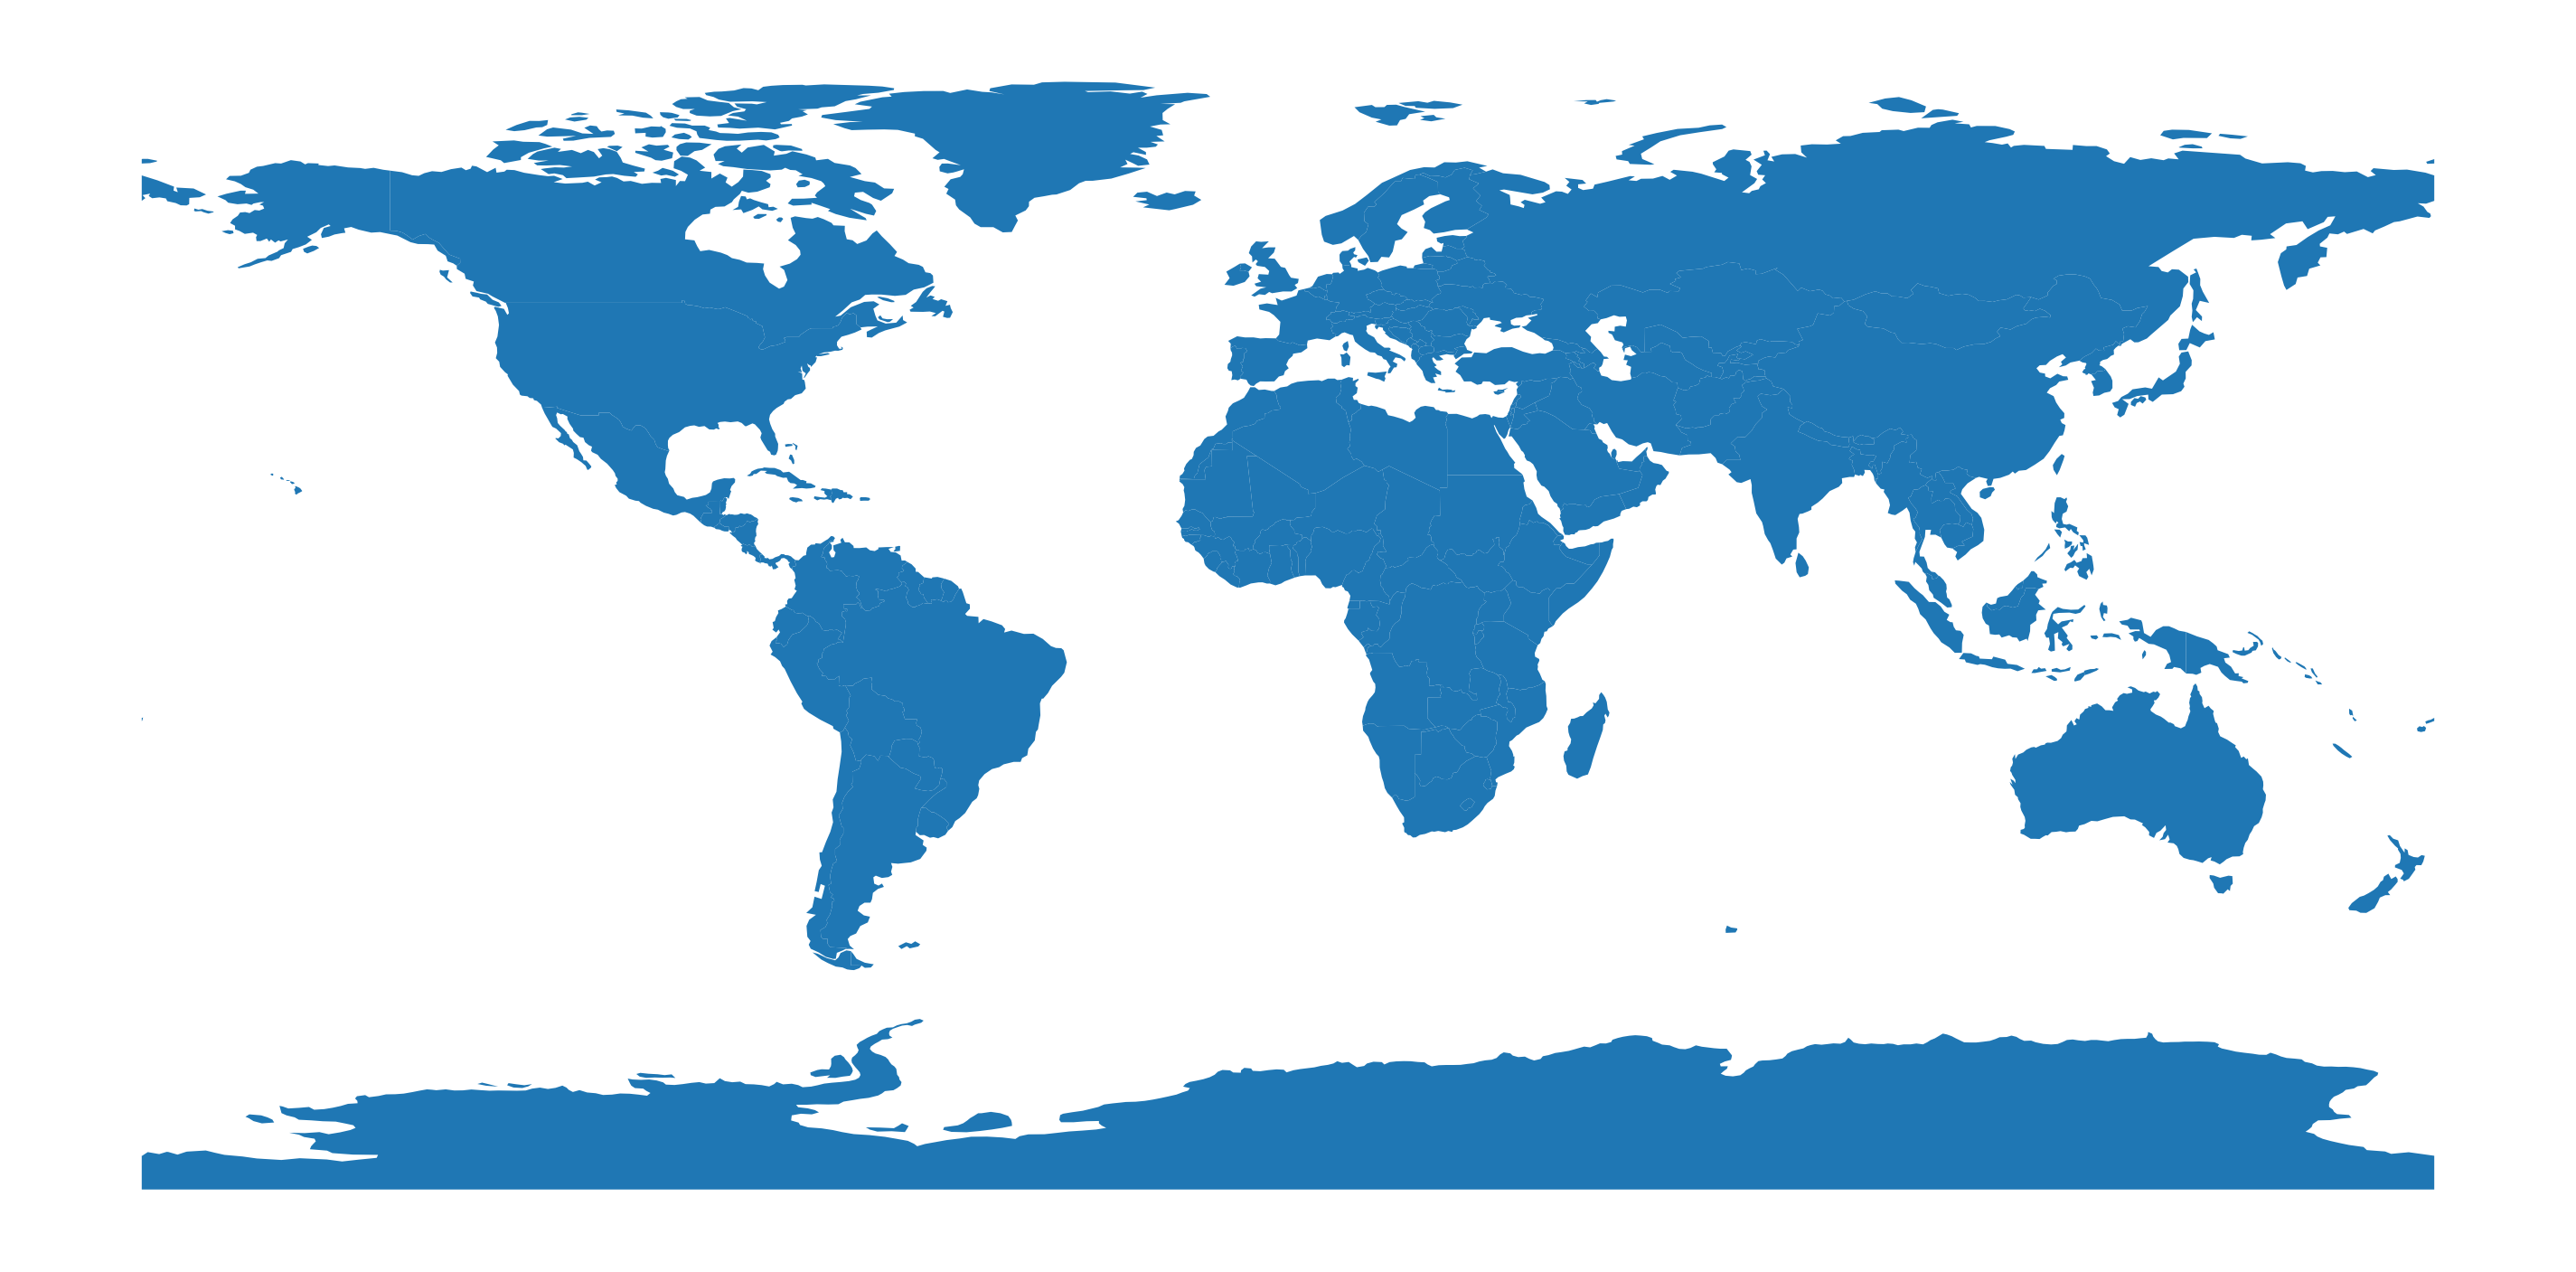

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_axis_off() # remove border around the axes
world.plot(ax=ax)

plt.show()

This projection is called PlateCarree. The default Matplotlib map plot often shows countries with varying shapes. Countries **near the equator appear relatively normal**, while those farther from the equator, especially near the poles, look **distorted**.

This occurs because the projection **stretches landmasses** more as they move away from the equator, causing countries near the poles to **spread horizontally** along the x-axis.


## The mercator projection

One of the most famous projection is called "Mercator". The Mercator projection maintains accurate direction by representing lines of constant course as straight segments, but it **distorts size and shape increasingly towards the poles**.

![](https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/animations/mercator.gif)

To change our previous chart projection to the Mercator projection, we follow these steps:

- initiate a `projection` variable using the `crs` module from `cartopy`
- change the polygon values in our `world` geodataframe
- pass our projection to `subplot_kw`


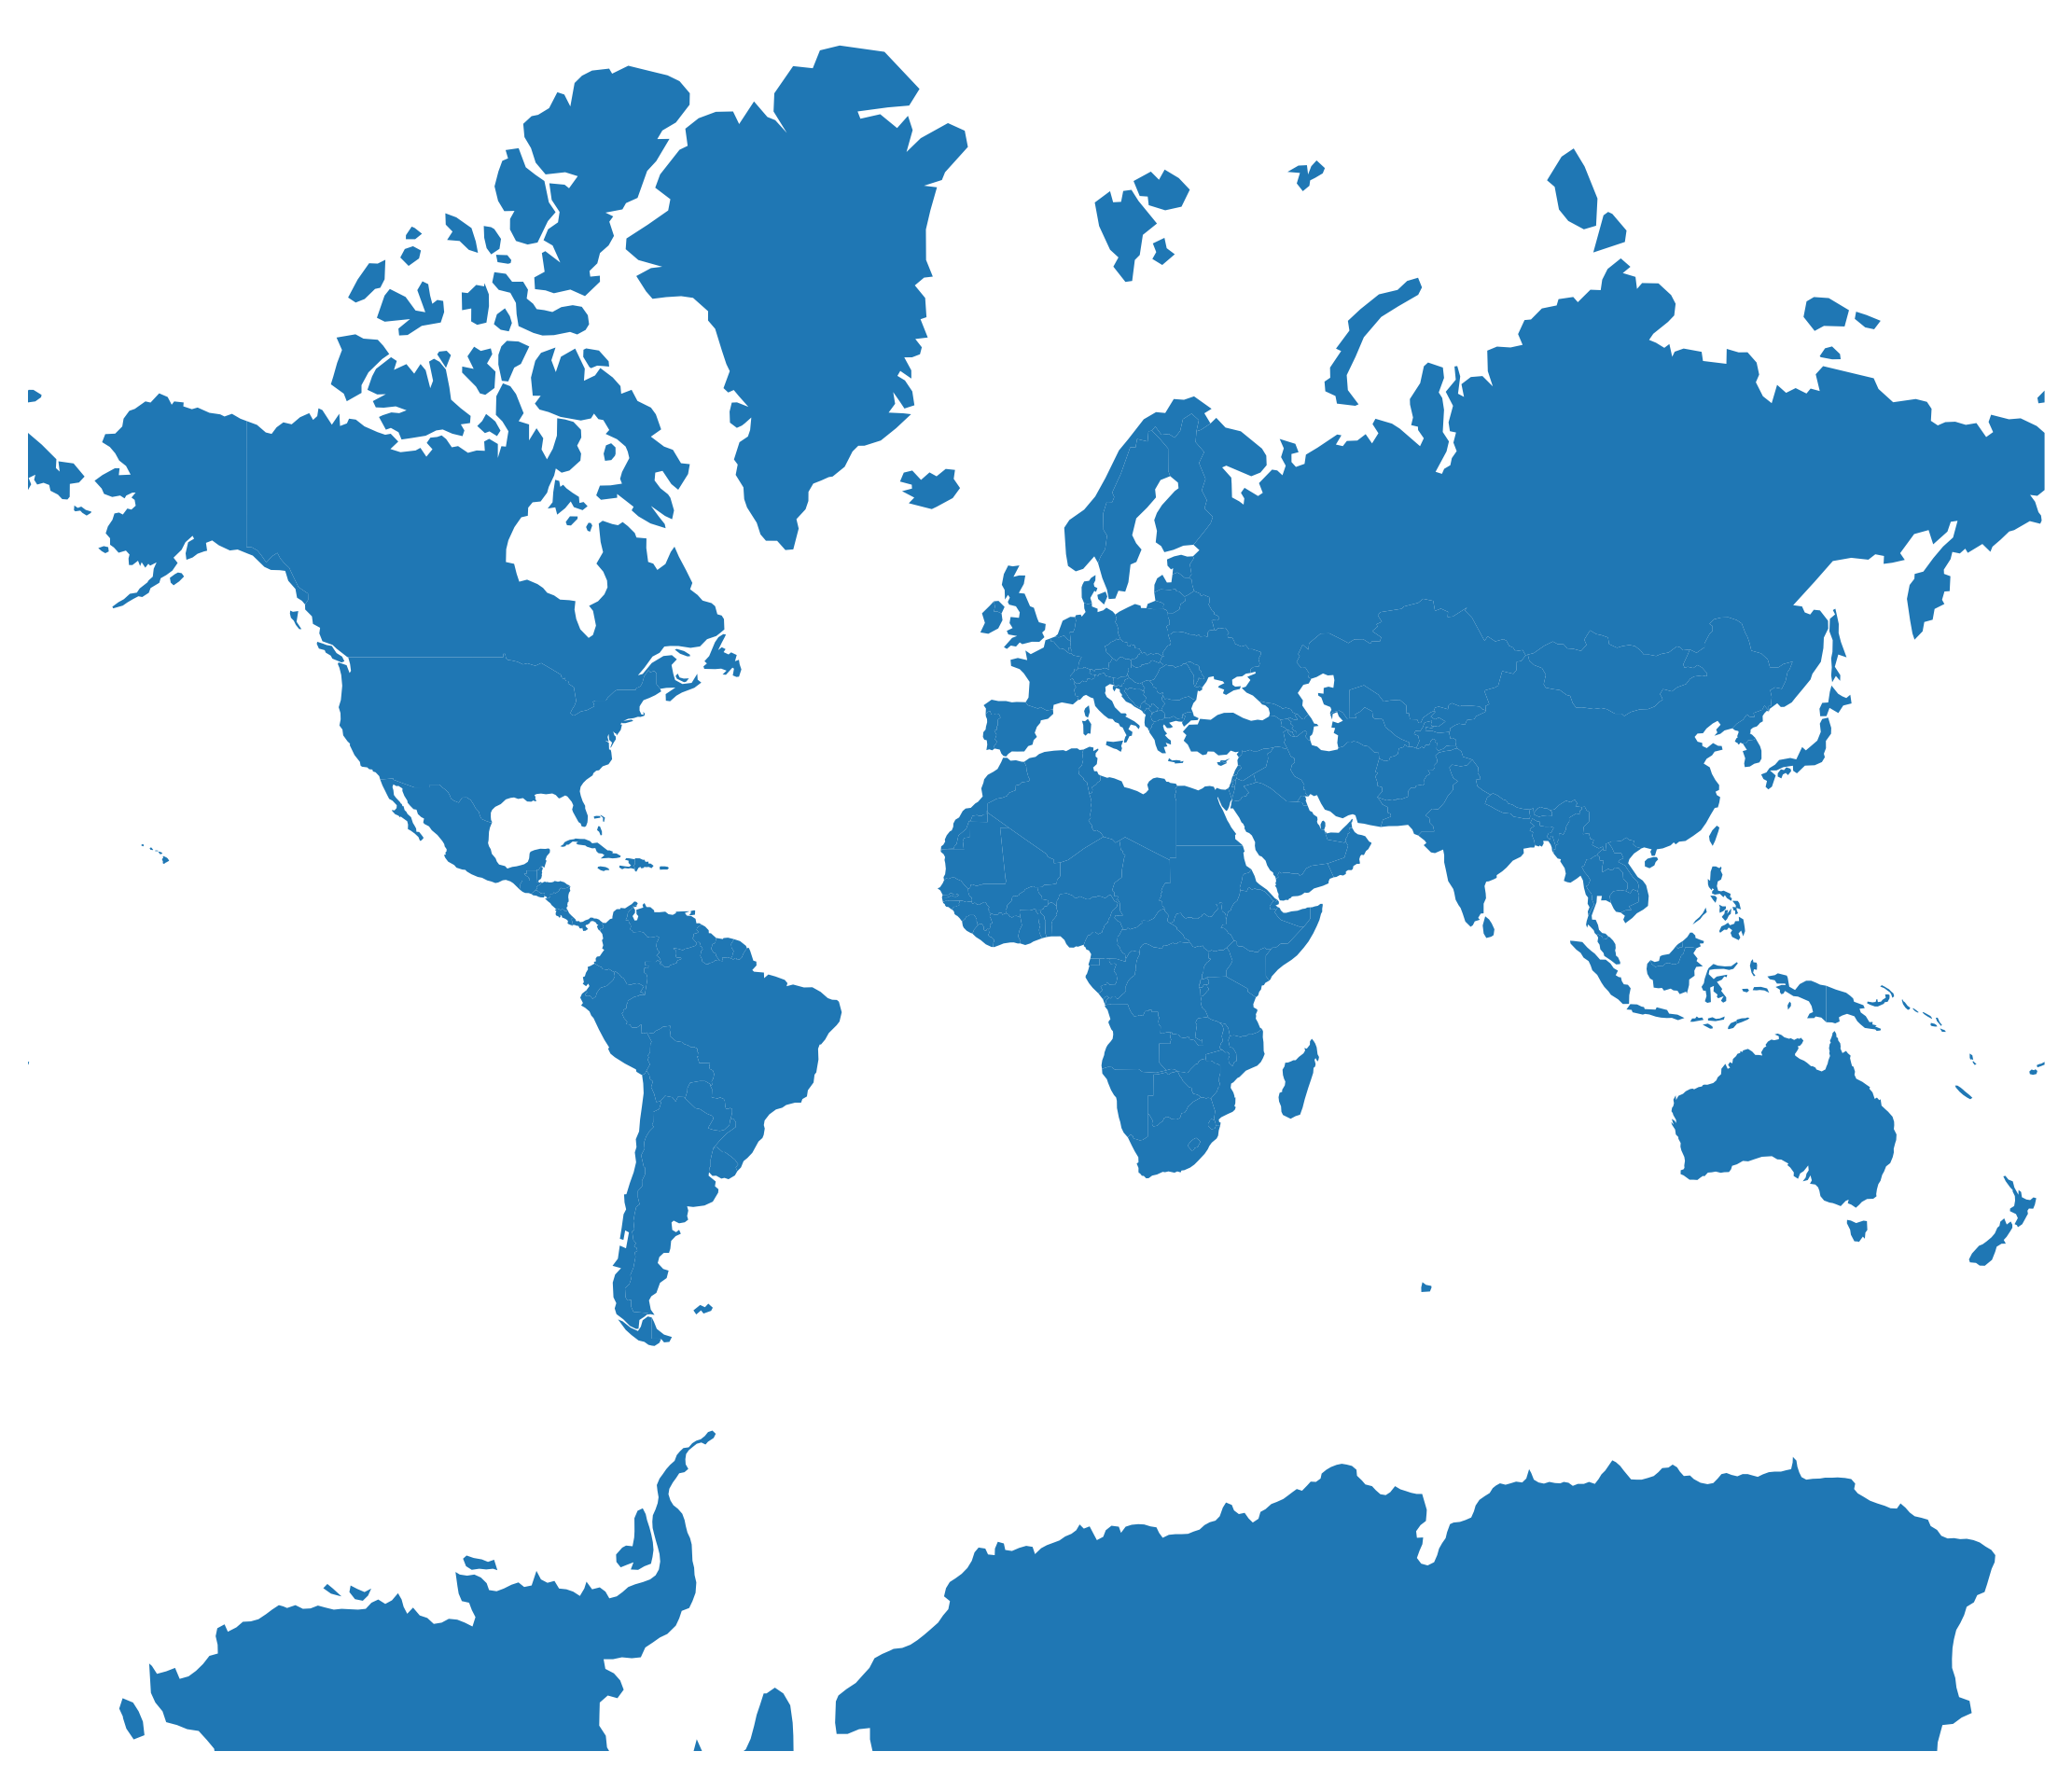

In [19]:
projection = ccrs.Mercator()
world_merc = world.to_crs(projection.proj4_init)

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": projection})

ax.set_axis_off() # remove border around the axes
world_merc.plot(ax=ax)

plt.show()

Our map looks way better, but the main problem with Mercator is that, for example, Greenland appears to be larger than Africa when in fact it is **14 times smaller**!


## Bubble maps and projections

A common map type is the [bubble map](/bubble-map), which overlays a [scatter plot](/scatter-plot) on a map, using longitudes as x-axis values and latitudes as y-axis values. However, simply changing the map projection **doesn’t automatically adjust** the scatter plot points accordingly.

Changing the projection alters the representation of the world's shape, thus shifting the actual locations of given latitudes and longitudes. Consequently, we **must recalculate the new positions** of each scatter plot point. Let's begin by loading a dataset with earthquake positions:


In [18]:
#Load data
url = "https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/earthquakes.csv"
df = pd.read_csv(url)
df = df[df['Depth (km)']>=0.01] # depth of at least 10 meters
df.sort_values(by='Depth (km)', ascending=False, inplace=True)
df.head()

,Date,Time (utc),Region,Magnitude,Depth (km),Latitude,Longitude,Mode,Map,year
7961,20/02/2019,06:50:47,Banda Sea,5.0,2026,-6.89,129.15,A,-,2019.0
6813,07/07/2019,07:50:53,"Eastern New Guinea Reg, P.N.G.",5.4,1010,-5.96,147.90,A,-,2019.0
8293,17/01/2019,14:01:50,Fiji Islands,4.7,689,-18.65,179.44,A,-,2019.0
11258,03/01/2018,06:42:58,Fiji Islands Region,5.5,677,-19.93,-178.89,A,-,2018.0
9530,06/09/2018,18:22:24,Fiji Islands Region,5.8,672,-18.88,179.30,A,-,2018.0


Now we add the earthquakes on our first map:


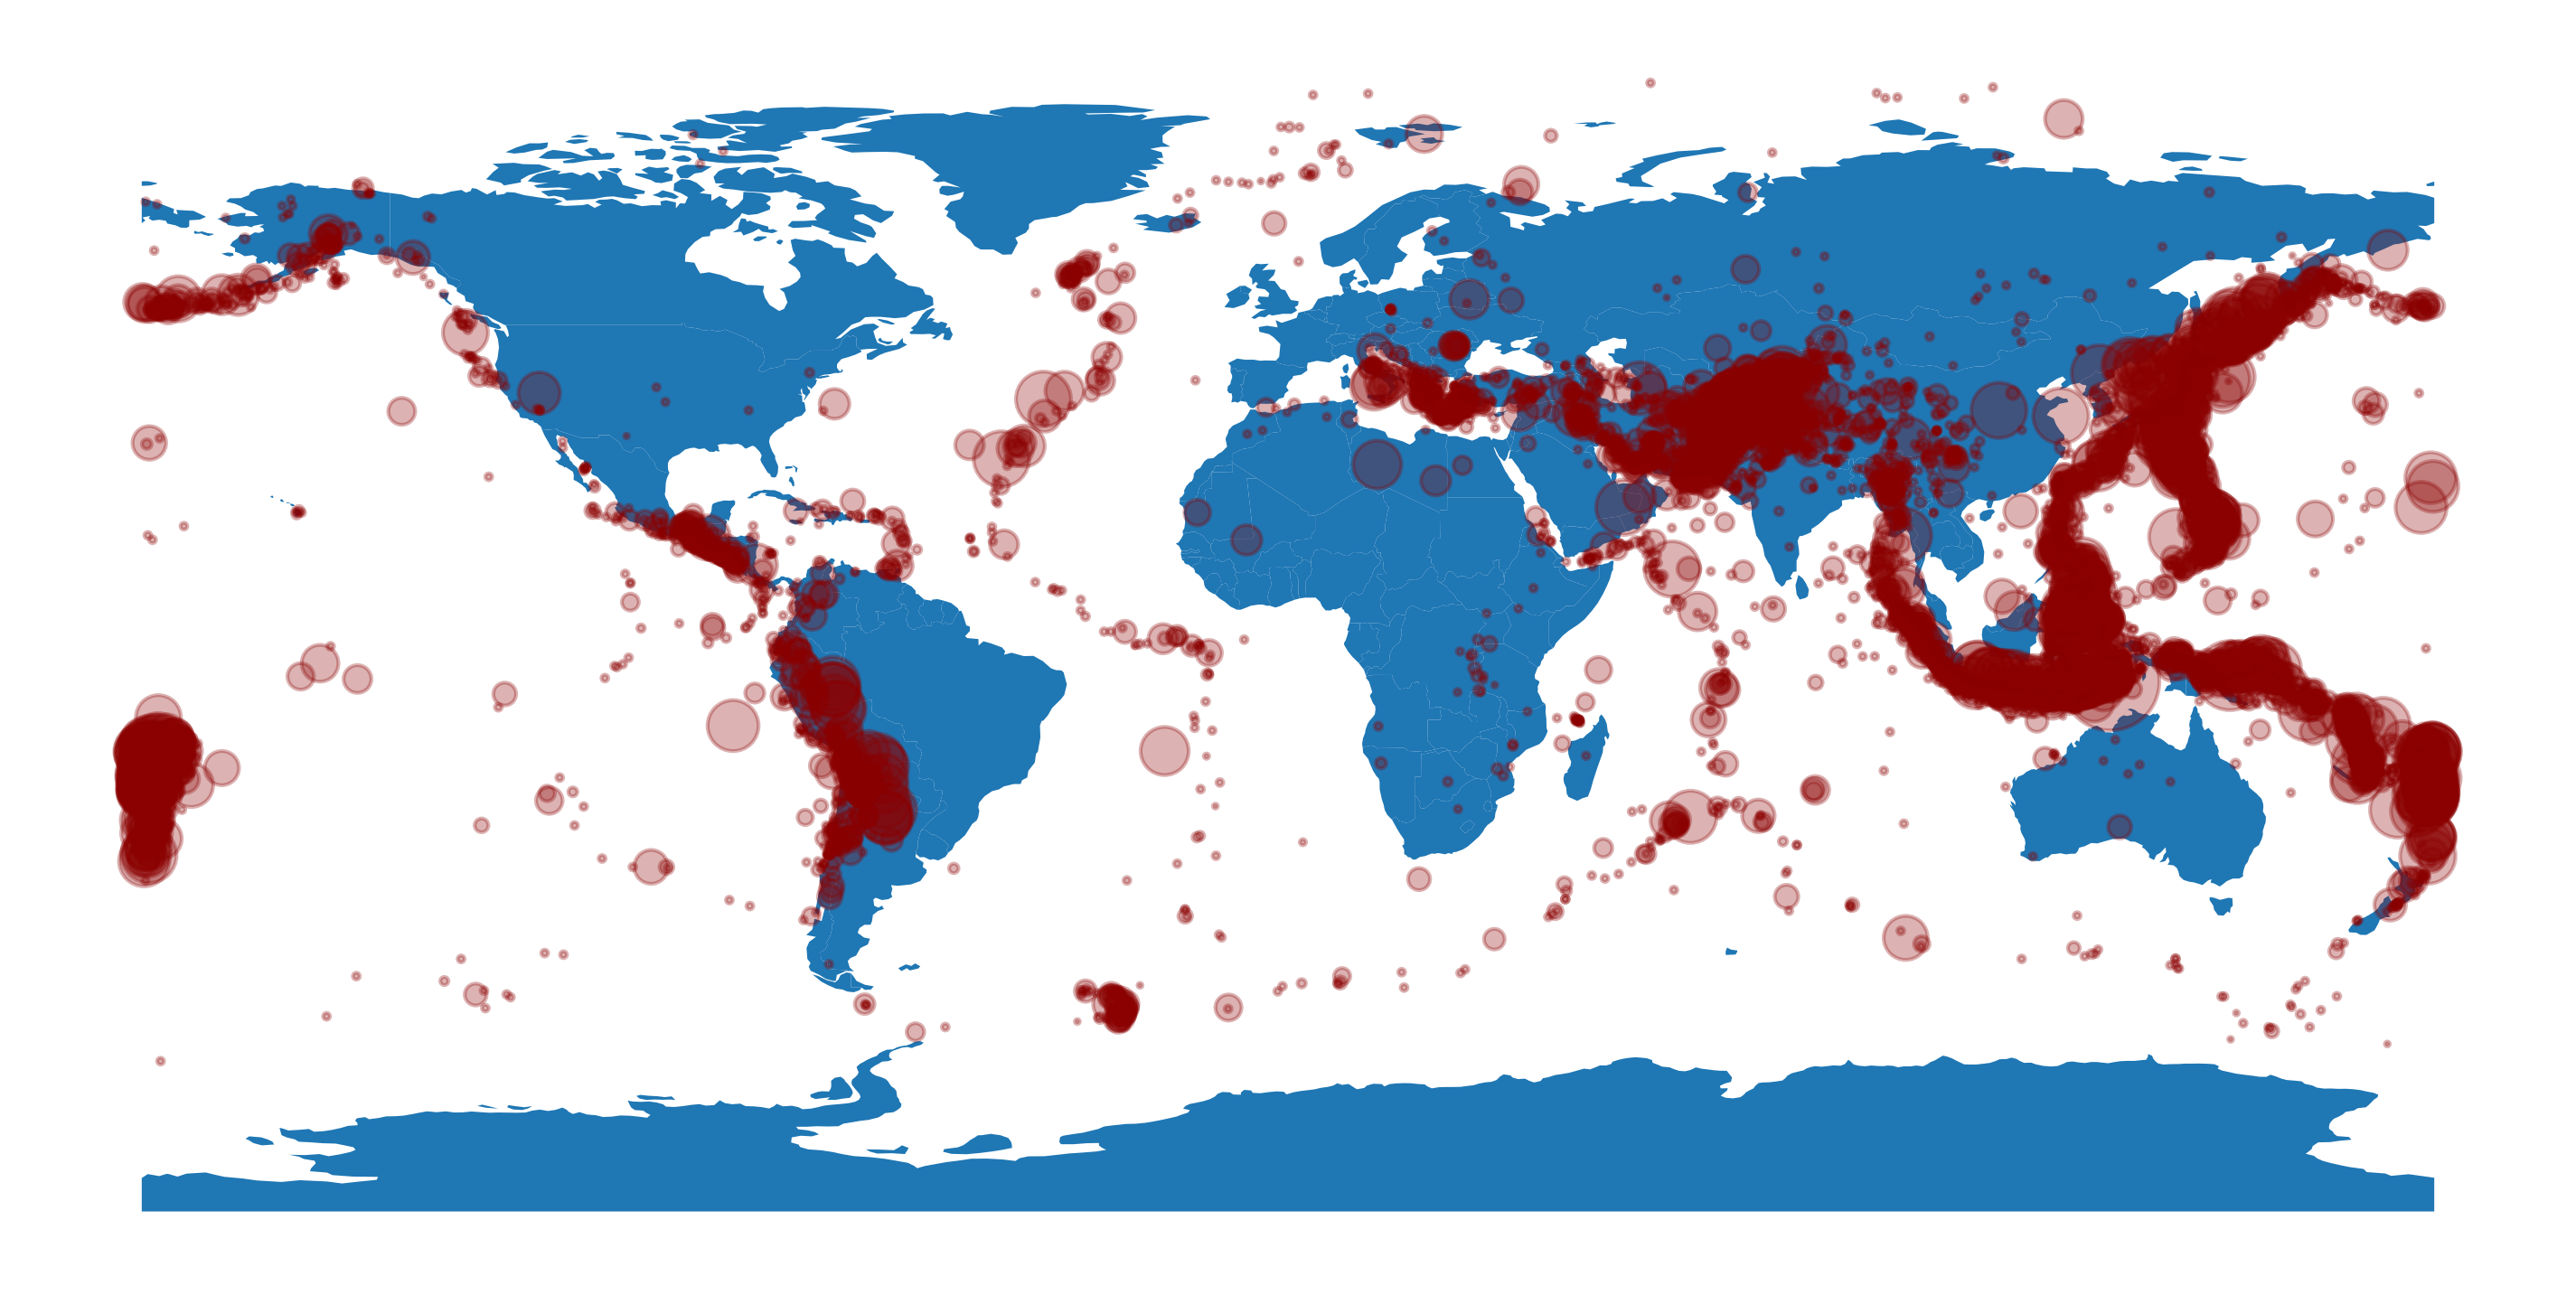

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_axis_off()
world.plot(ax=ax)
ax.scatter(
   x=df['Longitude'], y=df['Latitude'], s=df['Depth (km)']/3,
   color='darkred', alpha=0.3
)

plt.show()

If we want to use the Mercator projection in our bubble map, we have to do multiple things:

- define the wanted projection with Mercator -> `projection = ccrs.Mercator()`
- specify that our **current data projection** is PlateCarree `previous_proj = ccrs.PlateCarree()`
- **transform** the positions -> `new_coords = projection.transform_points(previous_proj, df['Longitude'].values, df['Latitude'].values)`
- **change** our background map projection -> `world_merc = world.to_crs(projection.proj4_init)`

Everything else stays the same: we just use `new_coords` when creating the scatter plot!


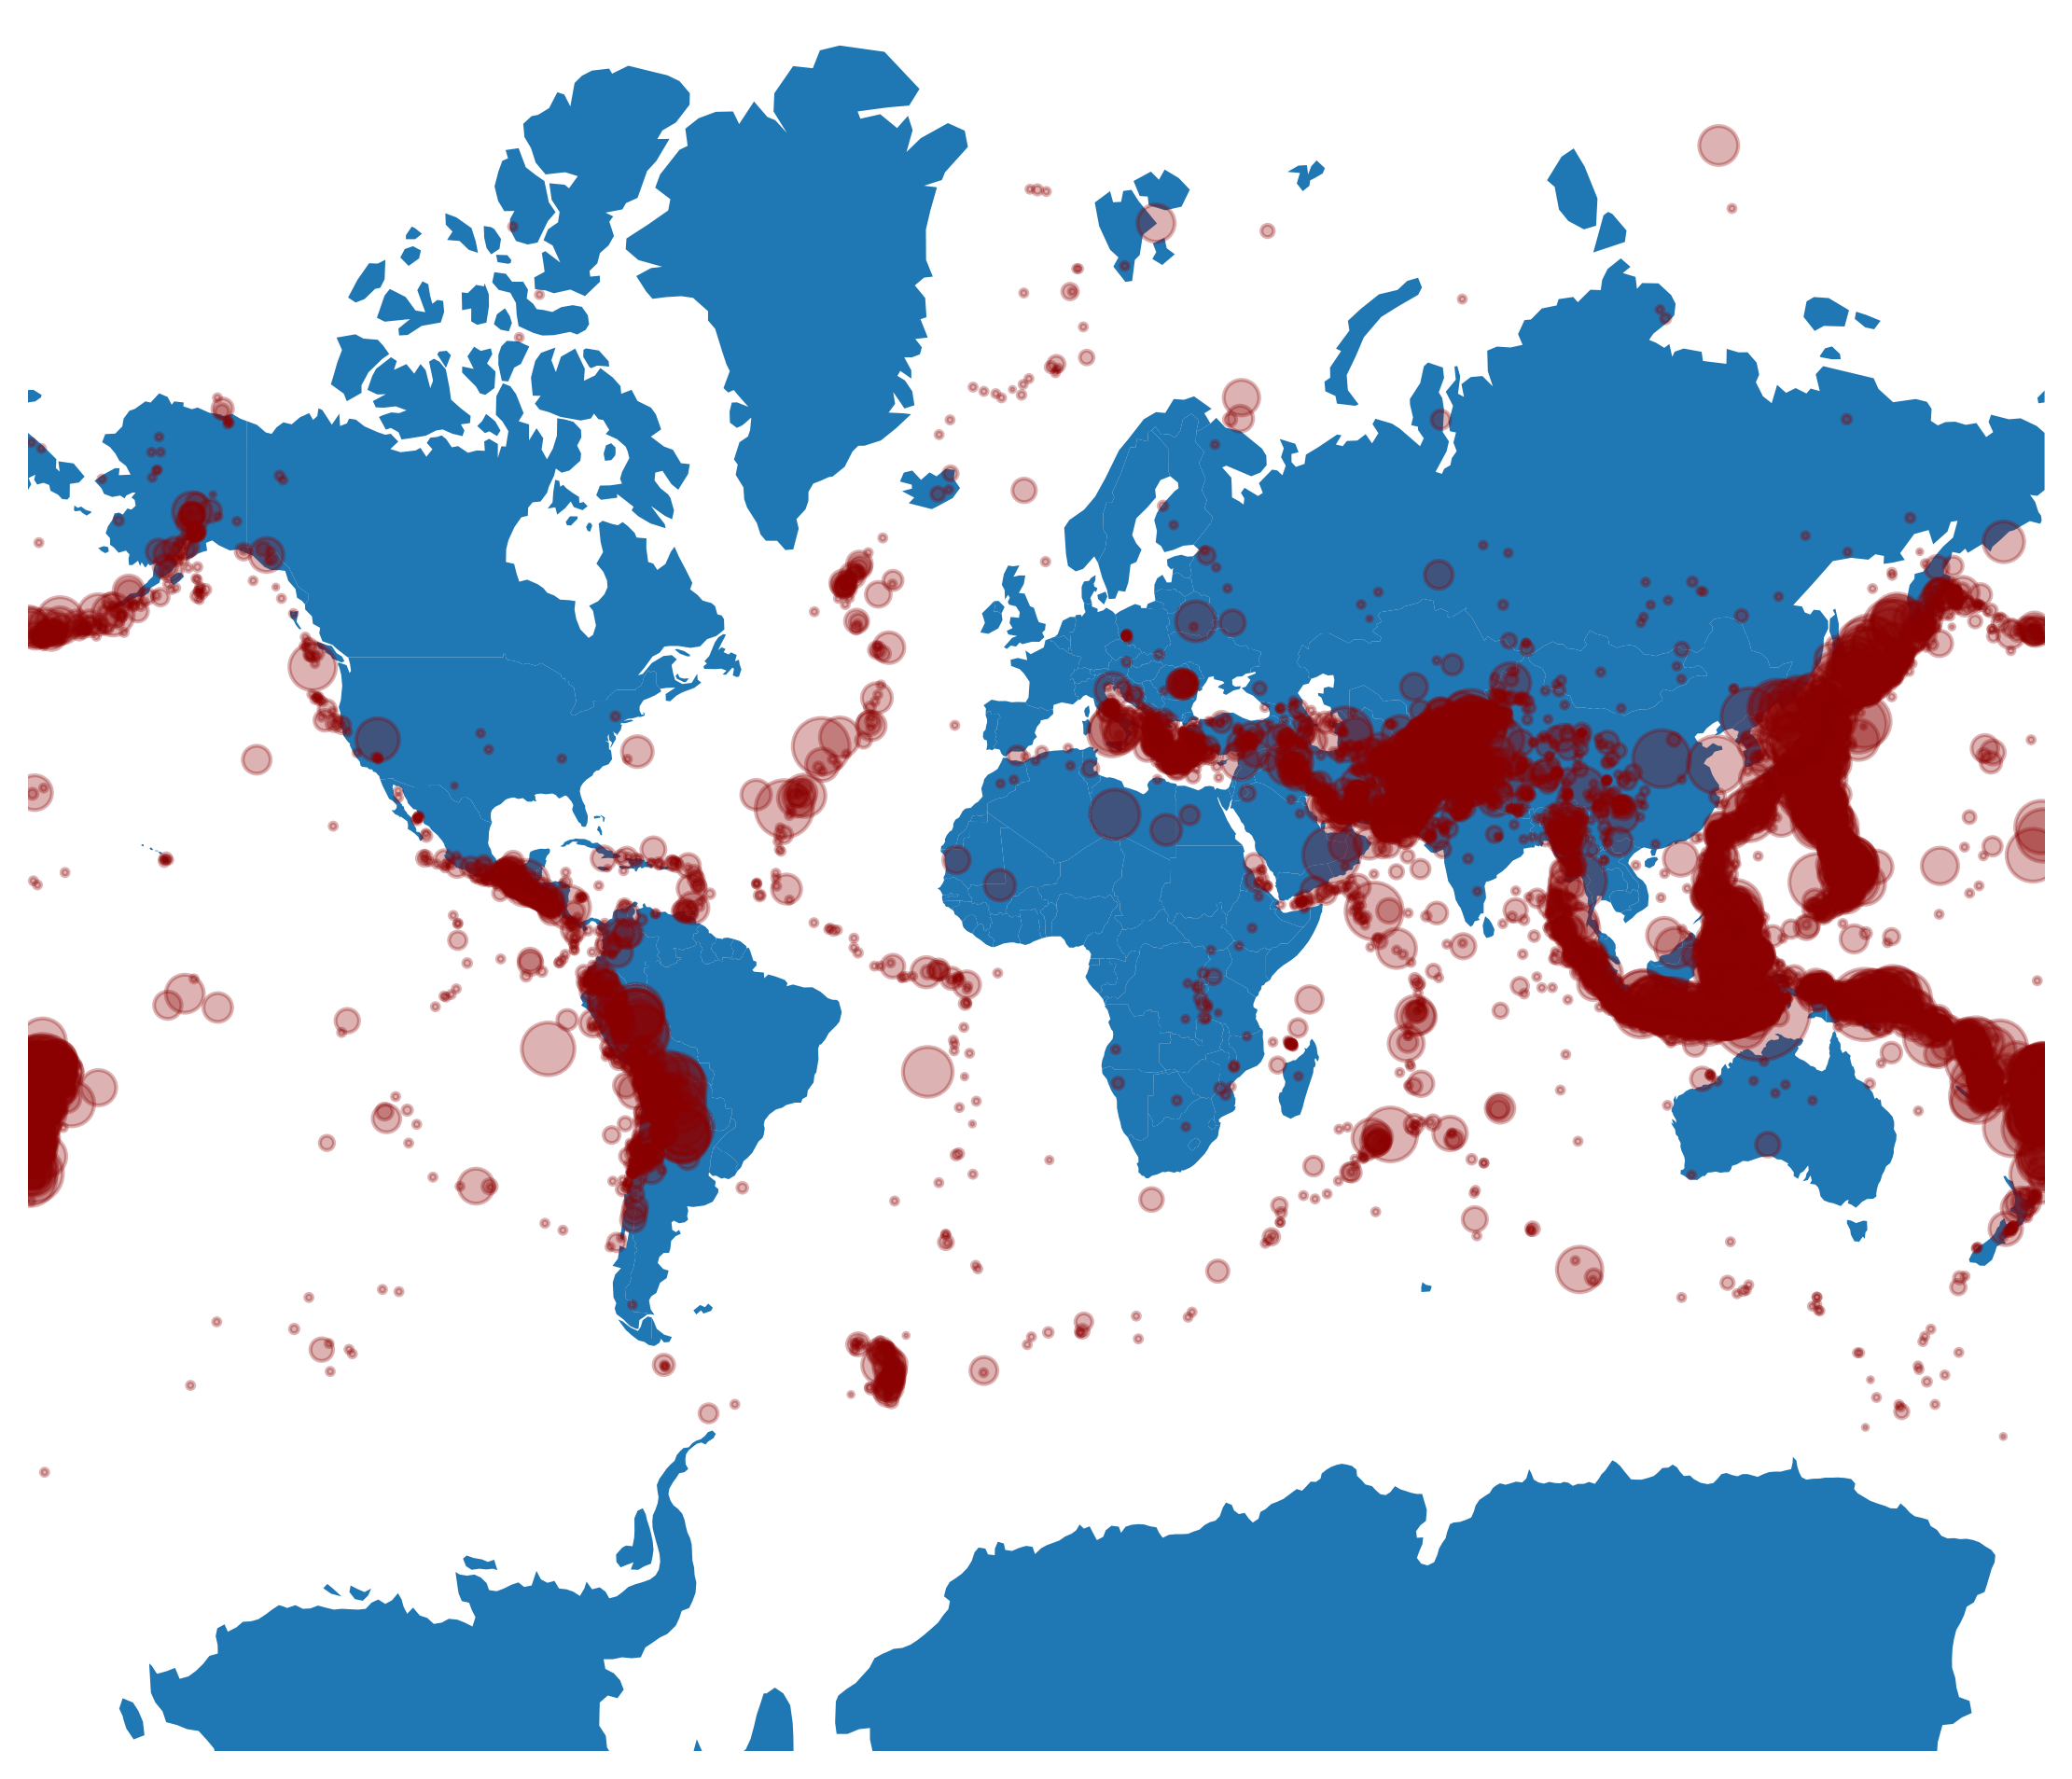

In [38]:
projection = ccrs.Mercator()
previous_proj = ccrs.PlateCarree()
new_coords = projection.transform_points(previous_proj, df['Longitude'].values, df['Latitude'].values)
world_merc = world.to_crs(projection.proj4_init)

fig, ax = plt.subplots(figsize=(12, 8), dpi=300, subplot_kw={'projection':projection})

ax.set_axis_off()
world_merc.plot(ax=ax)

# transform the coordinates to the projection's CRS
ax.scatter(
   x=new_coords[:, 0], y=new_coords[:, 1], s=df['Depth (km)']/3,
   color='darkred', alpha=0.3
)

plt.show()

## Other projections

The number of different projections is in fact **very large**. Below is an exhaustive list of the projections available in `cartopy` (the first ones are the most common ones, and recommended for most use cases):z

- `PlateCarree()`: most basic projection
- `AlbersEqualArea()`: preserves area, conical
- `AzimuthalEquidistant()`: preserves distance from center
- `EquidistantConic()`: preserves distance along meridians
- `LambertConformal()`: preserves shape, conical
- `LambertCylindrical()`: equal-area cylindrical
- `Mercator()`: preserves direction, exaggerates poles
- `Miller()`: compromise between Mercator and cylindrical
- `Mollweide()`: equal-area, elliptical
- `ObliqueMercator()`: rotated Mercator for oblique aspects
- `Orthographic()`: view from infinite distance
- `Robinson()`: pseudo-cylindrical, compromise
- `Sinusoidal()`: equal-area, pseudo-cylindrical
- `Stereographic()`: conformal, azimuthal
- `TransverseMercator()`: Mercator rotated 90 degrees
- `UTM()`: grid-based, preserves shape locally
- `InterruptedGoodeHomolosine()`: interrupted equal-area
- `RotatedPole()`: shifts pole position
- `OSGB()`: British National Grid
- `EuroPP()`: Europe polar stereographic
- `Geostationary()`: view from geostationary orbit
- `NearsidePerspective()`: view from finite distance
- `EckertI()`: pseudo-cylindrical, equal-area
- `EckertII()`: pseudo-cylindrical, equal-area
- `EckertIII()`: pseudo-cylindrical, compromise
- `EckertIV()`: pseudo-cylindrical, equal-area
- `EckertV()`: pseudo-cylindrical, compromise
- `EckertVI()`: pseudo-cylindrical, equal-area
- `Aitoff()`: modified azimuthal, compromise
- `EqualEarth()`: equal-area, pseudo-cylindrical
- `Gnomonic()`: straight great circles
- `Hammer()`: equal-area, elliptical
- `LambertAzimuthalEqualArea()`: equal-area, azimuthal
- `NorthPolarStereo()`: stereographic centered on North Pole
- `OSNI()`: Northern Ireland Grid
- `SouthPolarStereo()`: stereographic centered on South Pole


## Going further

You might be interested in:

- learn more about [maps in python](/map)
- how to create [an interactive map with Folium](/map/#Folium)
- how to [create and customize bubble maps](/bubble-map)
